# Body Fat - Rule of Thumb
#### Group Member: Yanshi Luo, Wang Lan, Peijin Li

## Introduction

Many research indicates that the percentage of body fat is related to human health. Although there are some measurements can be used to acuurately calculate body fat, they may be difficult and complicated to be obtained. Take the body density as example, Siri recorded this measurement in his research <cite data-cite="siri1956gross">(Siri, 1956)</cite> by the technique of underwater weighting, and used this record to calculate body fat. 

In this report, we will limit our measurements to commonly available measurements such as age, weight, and height to provide a clear,accurate and easy to use "Rule of Thumb" to estimate body fat for daily use.

## Data Background

The data set contains 17 measurements from 252 observations. Except for the first three column seperately is `IDNO`(id number), `BODYFAT`(The first-class outcome), and `DENSITY`(The second-class outcome), the rest 13 measurements are commonly available measurements of human body, which will be used as possible predictors in the model.

.....

## Data Cleaning

In [3]:
BodyFat <- read.csv("../data/BodyFat.csv");


To get the numerical result for the body fat estimation, we consider the outcome as `BODYFAT` (If not valid, can be approximately translated from `DENSITY`)

In [59]:
summary(BODYFAT)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   12.80   19.00   18.94   24.60   45.10 

By analysising the `BODYFAT` variable, we can see that #182 and #216 observations have extreme values of body fat, seperately 0 and 45.1.

We consider that these two value is not valid and try to transform the second-class y `DENSITY` to `BODYFAT`  with Siri's equation <cite data-cite="siri1956gross">(Siri, 1956)</cite>  $B= 495/D - 450$ and get -3.61 and 47.49 seperately, which are still not in a normal range of body fat. Thus we **delete** these two observations from the data set.

<!--bibtex

@article{siri1956gross,
  title={The gross composition of the body},
  author={Siri, William E and others},
  journal={Adv Biol Med Phys},
  volume={4},
  number={239-279},
  pages={513}
}
-->

By analysing the Cook's distance of the linear model build from `lm(BODYFAT ~ .)`(all possible $X$ dispite of `ID` and `DENSITY`), we look into details of the outlier candidates with ID 42, 39 and 86.

Observation #42 is weighted 205 lb and 29.5 in tall. Body Mass Index (BMI) is commonly used to classify underweight, overweight and obesity in adults. Usually a person with BMI $>=$ 40 is considered to be extreme obese [(WHO 
BMI classification)](http://apps.who.int/bmi/index.jsp?introPage=intro_3.html). When we calculate the BMI, we can see that this observation is very abnormal with BMI = 165.62, so we consider this observation as an invalid record and delete it from the model.

Obs. 39 is a very fat guy with most of his record as the maximum one in the data and by the Scale-Location plots below, we can see that #39 has an extreme residuals. Thus we consider to delete it from the dataset to obtain a robust result.  

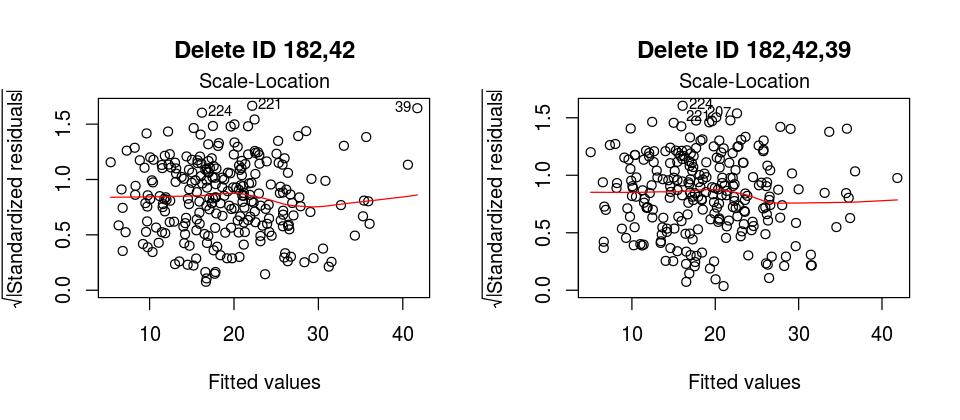

In [61]:
d1 <- BodyFat[-c(182,42),] ## Delete abnormal point
d2 <- BodyFat[-c(182,42,39),] ## Delete Influential Point

fit1 <- lm(BODYFAT~.-IDNO-DENSITY,data = d1); fit2 <- lm(BODYFAT~.-IDNO-DENSITY,data = d2)

options(repr.plot.width=8, repr.plot.height=3.5); par(mfrow=c(1,2))
plot(fit1, which=3); title(main = "Delete ID 182,42") ### LEFT
plot(fit2, which=3); title(main = "Delete ID 182,42,39") ### RIGHT

For other observations with extreme values, we also do some explaratory analysis.The `Keep OR Delete` result is listed as follows.

| ID  | Why Abnormal                                         | Action |
|-----|------------------------------------------------------|--------|
| 182 | BodyFat = 0 (failed to be recalculated from Density) | Delete |
| 42  | BMI = 165 (Very Extreme BMI)                         | Delete |
| 39  | Weight = 363.15 (Extreme Fat)                        | Delete |
| 79  | Age = 81 (Extreme Old)                               | Keep   |

## Statistical Model

In [2]:
dat = read.csv("../data/BodyFat.csv")
datset = dat[-c(39,42,182),-c(1,3)]     # Remove IDNO and DENSITY
rg_full = lm(BODYFAT~.,data = datset)

base<-lm(BODYFAT~1,data=datset)
model.AIC<-step(rg_full,direction="backward",k=2,trace = 0)
model.BIC<-step(rg_full,direction="backward",k=log(dim(datset)[1]),trace = 0)

base.AIC<-step(base,direction="both",scope=list(lower=~1,upper=rg_full),trace=0)
base.BIC<-step(base,direction="both",scope=list(lower=~1,upper=rg_full),trace=0,k=log(dim(datset)[1]))

base.AIC.forward<-step(base,direction="forward",scope=list(lower=~1,upper=rg_full),trace=0)
base.BIC.forward<-step(base,direction="forward",scope=list(lower=~1,upper=rg_full),trace=0,k=log(dim(datset)[1]))

Start from the cleaned dataset, we applied backwards, forwards, stepwise selection to reduct variables number. The stepwise and forwards result are same.

Also the criteria for this selection method is AIC and BIC. AIC and BIC is an index which combine balancing goodness of fit and model complexity. Higher AIC(BIC) means bad model fitting or complexity is too high. The table below shows the result for these model.

|model|    method     |           selected variables                     |Multiple $R^2$|adjusted $R^2$| RSE |
|-----|---------------|--------------------------------------------------|--------------|--------------|-----|
| m1  |backwards (AIC)|AGE,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,FOREARM,WRIST|  0.7433      |0.7347        |3.916|
| m2  |backwards (BIC)|AGE,ADIPOSITY,CHEST,ABDOMEN,WRIST                 |  0.7354      |0.7299        |3.951|
| m3  |stepwise  (AIC)|AGE,ABDOMEN,WEIGHT,WRIST,BICEPS                   |  0.7356      |0.7301        |3.95 |
| m4  |stepwise  (BIC)|ABDOMEN,WEIGHT,WRIST                              |  0.7292      |0.7259        |3.981| 

From the table we can recognize, although the m4 has minimum multiple $R^2$ and adjusted $R^2$, and has highest RSE, m4 has the simplest form and minimum variable number. According the Occam Razor priciple, we choose m4 as our final model format.

The final model is $$BODYFAT = -23.99+0.88*ABDOMEN-0.087*WEIGHT-1.28*WRIST$$. 
wehere the scale seperately is: cm(ABDOMEN), cm(WRIST), lbs(WEIGHT).

- The ABDOMEN has positive relationship with bodyfat. Every 1cm ABDOMEN increase indicate 0.88476 bodyfat increment.
- The WEIGHT and WRIST has negative relationship with bodyfat.Every 1cm WEIGHT increase indicate -0.08678 bodyfat decrement.Every 1cm WRIST increase indicate -1.28161 bodyfat decrement

The variable estimated coefficient and standard errors and p-value are showing below. They are all siginificant based on the p-value.

| variable | Est.coefficient |Std. Error | P-value |
|----------|-----------------|-----------|---------|
|Intercept |     -23.99356   |   6.23603 | 0.000152|
|ABDOMEN   |      0.88476    |  0.05108  |< 2e-16  |
|WEIGHT    |      -0.08678   |   0.02234 |0.000132 |
|WRIST     |      -1.28161   |   0.40274 | 0.001650|

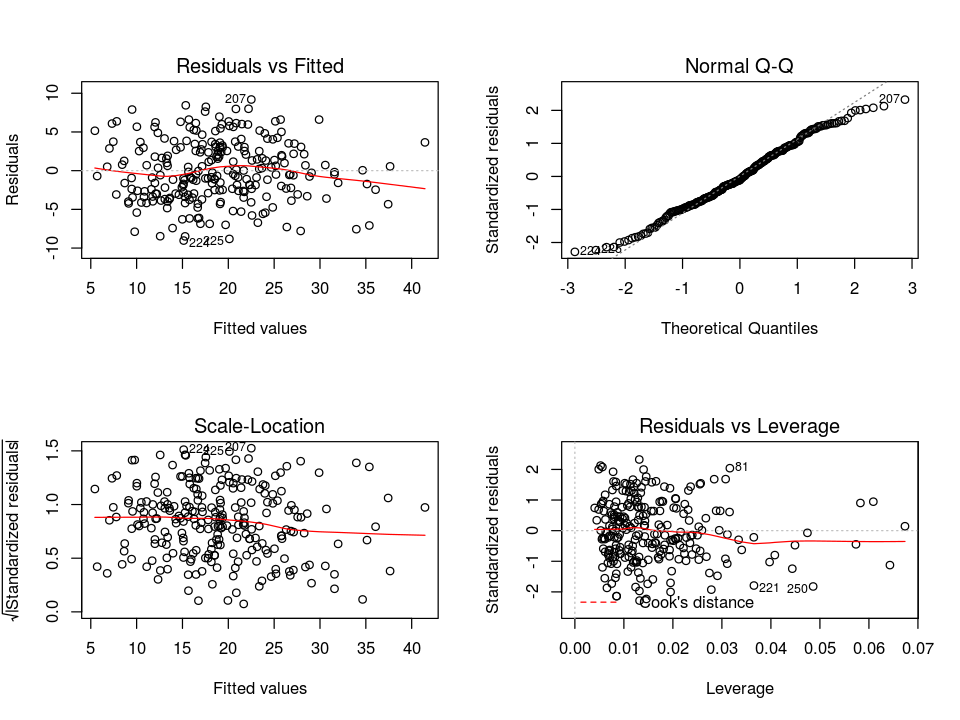

In [4]:
options(repr.plot.width=8, repr.plot.height=6)
par(mfrow = c(2,2))
plot(base.BIC)

- From aspect of residual plots, points're symmetrically distributed,  clustered towards the middle of the plot, and didn't have clear patterns in both models. This means no information remains in the residuals and assumption of equal variance is satisfied.

- From aspect of QQ-plots, most points are on the diagnol line of QQ-plot in both models. This means normal distribution assumption is also satisfied.

- From aspect of Cook's distance and leverage of all observations, we can see that 81,221 and 250 are relatively high influential points. However, after we deleted those points and use stepwise method again, they won't change chosen variables. What's more, there's nothing abnormal about those high influential points after we checked their values. So we decided to keep them.

In [64]:
library(car)
t(sqrt(vif(base.BIC)))

ABDOMEN,WEIGHT,WRIST
2.045887,2.370198,1.448709


- Based on Occam's Razor principle, we chose the best model given by BIC rule, which is 
$$BODYFAT = -23.99+0.88*ABDOMEN-0.087*WEIGHT-1.28*WRIST$$.

#### Possible rule of thumb

> 90% of your circumsference of waist, minus 10% of weight, minus 130% of your circumsference of wrist, and minus 24.

- This rule of thumb is close to our estimated model by constructing 95% confidence intervals.

#### Example Usage
For a man who weights 170lb, with abdomen circumsference of 90cm and 15cm-wrist-circumsference, his bodyfat rate will be predicted as 17.81%. There is a 95% probability that his body fat is between 0.10% and 25.67%. 

With rule of thumb, we get about 24.5% as the predicted bodyfat rate.

#### Inference about relationship
All these three variables are significantly(at level of $\alpha = 0.05$) associated with bodyfat.What's more, they can explain over 70% of variation in BODYFAT. 1cm increase in abdomen circumsference will cause 0.9% increase in bodyfat rate, 1cm decrease in wrist circumsference will cause 1.3% increase in bodyfat rate and 1lb decrease in weight will cause 0.1% increase in bodyfat rate. 

#### Strength and Weakness

Although it has some drawbacks, we think multivariable linear regression model is a reasonable model for this dataset.

1.Linearity assumption is reasonable based on residual plots.

2.Normality assumption about errors is reasonable based on QQ plot, we showed above.

3.Constant variance assumption is reasonable because residual plots doesn't have an obvious shape.

4.R-square is larger than 0.7 and there're only 3 indepent variables in the model. This means this model refines most of information in the data and has a very simple form.

5.Multivariable linear regression provides unbiased estimators of coefficients.

6.Multicollinearity is a problem in this model. It could influence accuracy of estimator of standard error, decrease credibility of t-test and enlarge width of confidence interval. 

Overall, our model provides a very simple way of predicting the body fat % based on weight, circumsference of waist and circumsference of wrist. However, because of its simplicity, our predictions aren't very precise because of multicollinearity.

## Reference

Siri, W.E. (1956), "Gross composition of the body", in _Advances in  Biological and Medical Physics_, vol. IV, edited by J.H. Lawrence and C.A. Tobias, Academic Press, Inc., New York.

WHO :: *Global Database on Body Mass Index*, Retrieved February 3, 2018, from http://apps.who.int/bmi/index.jsp?introPage=intro_3.html